# Regression ABC using MDNs
MDN implementation based on this tutorial: https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from pyabc.examples import tuberculosis
import pyabc

import torch
from torch.autograd import Variable
import torch.nn as nn

## GMM example
Let's first consider the simple example of an equally weighted mixture of Gaussians with equal mean. One of them with a std of 1, the other 0.1.

In [2]:
def simulator(mu):
    if np.random.rand() < 0.5:
        return np.random.normal(mu,1)
    else:
        return np.random.normal(mu,0.1)
    
def posterior(mu):
    return 0.5 * ss.norm.pdf(mu, 0, 1) + 0.5 * ss.norm.pdf(mu, 0, 0.1)

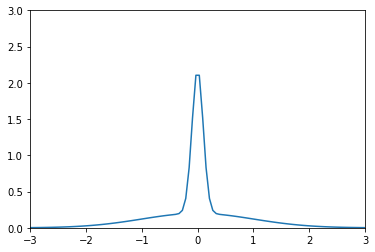

In [3]:
xx = np.linspace(-3,3,100)
plt.figure()
plt.plot(xx, posterior(xx))
plt.xlim((-3,3))
plt.ylim((0,3))
plt.show()

In [4]:
x_obs = 0.0

We use a uniform prior and generate 2500 samples, from which we generate the training set for our MDN.

In [5]:
NSAMPLE = 10_000

theta = np.random.uniform(-2, 4, NSAMPLE)
theta.shape

(10000,)

In [6]:
x_data = np.array([simulator(theta_i) for theta_i in theta])
#x_data = summarize(x)
x_data.shape

(10000,)

Here, we adjust the number of hidden units and mixture components in the MDN

In [7]:
NHIDDEN = 20 # hidden units
KMIX = 2 # number of mixtures

In [8]:
class MDN(nn.Module):
    def __init__(self, hidden_size, num_mixtures, input_dim):
        super(MDN, self).__init__()
        self.fc_in = nn.Linear(input_dim, hidden_size) 
        self.tanh = nn.Tanh()
        self.pi_out = torch.nn.Sequential(
              nn.Linear(hidden_size, num_mixtures),
              nn.Softmax()
            )
        self.sigma_out = nn.Linear(hidden_size, num_mixtures)
        self.mu_out = nn.Linear(hidden_size, num_mixtures)  

    def forward(self, x):
        out = self.fc_in(x)
        out = self.tanh(out)
        out_pi = self.pi_out(out)
        out_sigma = torch.exp(self.sigma_out(out))
        out_mu = self.mu_out(out)
        return (out_pi, out_sigma, out_mu)

Convert the training examples to torch tensors.

In [9]:
x_train = Variable(torch.from_numpy(x_data.reshape(NSAMPLE, 1)).float())
theta_train = Variable(torch.from_numpy(theta.reshape(NSAMPLE, 1)).float(), requires_grad=False)

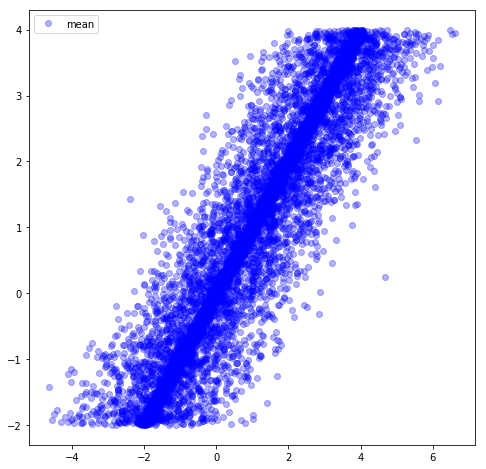

In [10]:
plt.figure(figsize=(8, 8))
plt.plot(x_train.data.numpy()[:,0],theta_train.data.numpy(),'bo', alpha=0.3, label='mean')
#plt.plot(x_train.data.numpy()[:,1],theta_train.data.numpy(),'ro', alpha=0.3, label='std')
plt.legend()
plt.show()

We now define the loss function, which is simply the negative log likelihood of the training data under our model.

In [11]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalisation factor for gaussian.
def gaussian_distribution(theta, mu, sigma):
    # braodcast subtraction with mean and normalization to sigma
    result = (theta.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = - 0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

In [12]:
def mdn_loss_function(out_pi, out_sigma, out_mu, theta):
    result = gaussian_distribution(theta, out_mu, out_sigma) * out_pi
    result = torch.sum(result, dim=1)
    result = - torch.log(result)
    return torch.mean(result)

In [13]:
model = MDN(hidden_size=NHIDDEN, num_mixtures=KMIX, input_dim=1)

In [14]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(10000):
    (out_pi, out_sigma, out_mu) = model(x_train)
    loss = mdn_loss_function(out_pi, out_sigma, out_mu, theta_train)
    if (t % 500 == 0):
        print(t, loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 2.271442174911499
500 0.7962024807929993
1000 0.5500250458717346
1500 0.5420095920562744
2000 0.5393167734146118
2500 0.5364786386489868
3000 0.5330325961112976
3500 0.5289276242256165
4000 0.5243791341781616
4500 0.5193198323249817
5000 0.5137599110603333
5500 0.5105425715446472
6000 0.5075958371162415
6500 0.5058561563491821
7000 0.5045917630195618
7500 0.5035130977630615
8000 0.5025203824043274
8500 0.5016209483146667
9000 0.5008005499839783
9500 0.5000494718551636


In [15]:
x_test = Variable(torch.from_numpy(np.array(x_obs).reshape(1, 1)).float())

In [16]:
(out_pi_test, out_sigma_test, out_mu_test) = model(x_test)

out_pi = out_pi_test.data.numpy().T
out_sigma = out_sigma_test.data.numpy().T
out_mu = out_mu_test.data.numpy().T

In [17]:
xx = np.linspace(-3,3,100)

In [18]:
pdf = np.array([ss.norm.pdf(xx, mu, sigma) * pi for mu, sigma, pi in zip(out_mu, out_sigma, out_pi)])
pdf = pdf.sum(axis=0)

In [19]:
pdf.shape

(100,)

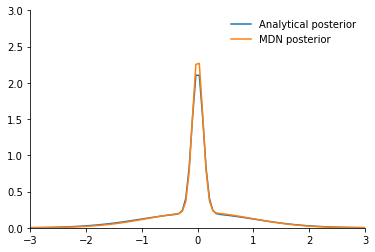

In [20]:
xx = np.linspace(-3,3,100)
f, ax = plt.subplots()
ax.plot(xx, posterior(xx), label='Analytical posterior')
ax.plot(xx, pdf, label='MDN posterior')
ax.set_xlim((-3,3))
ax.set_ylim((0,3))
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('regression_abc_gmm.pdf')

## Tuberculosis example

In [71]:
alpha = 0.2
delta = 0
tau = 0.198
m = 20
N = 2e7

prior_alpha = pyabc.Prior("uniform", 0.005, 2, name=r"$\alpha$")
#prior_tau = pyabc.Prior("uniform", 0.01, 1, name="$\tau$")

list_of_priors = [prior_alpha]

simulator = tuberculosis.simulator

params = [alpha, tau, delta]

y0 = np.array([6,3,2,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0]) # from paper

In [72]:
# create training set
NSAMPLE = 1000

alpha_train = prior_alpha.sample(size=NSAMPLE)
x_train = np.array([simulator(float(alpha_i)) for alpha_i in alpha_train])

In [73]:
NHIDDEN = 50
KMIX = 20
INPUT_DIM = 20

model = MDN(hidden_size=NHIDDEN, num_mixtures=KMIX, input_dim=INPUT_DIM)

In [74]:
x_train = Variable(torch.from_numpy(x_train.reshape(NSAMPLE, INPUT_DIM)).float())
theta_train = Variable(torch.from_numpy(alpha_train.reshape(NSAMPLE, 1)).float(), requires_grad=False)

In [75]:
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(50_000):
    (out_pi, out_sigma, out_mu) = model(x_train)
    loss = mdn_loss_function(out_pi, out_sigma, out_mu, theta_train)
    if (t % 500 == 0):
        print(t, loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 1.595661997795105
500 0.3137557804584503
1000 0.13642531633377075
1500 0.043145593255758286
2000 -0.028910141438245773
2500 -0.14086800813674927
3000 -0.2176455855369568
3500 -0.2592397928237915
4000 -0.322463721036911
4500 -0.31573301553726196
5000 -0.38182559609413147
5500 -0.2946167588233948
6000 -0.3851380944252014
6500 -0.4479975402355194
7000 -0.6486160159111023
7500 -0.6621840000152588
8000 -0.7301026582717896
8500 -0.7825160026550293
9000 -0.7197278738021851
9500 -0.8202037811279297
10000 -0.7522083520889282
10500 -0.6506230235099792
11000 -0.712567150592804
11500 -0.6811548471450806
12000 -0.7611348628997803
12500 -0.6765670776367188
13000 -0.7063235640525818
13500 -0.6524644494056702
14000 -0.6078741550445557
14500 -0.6878088712692261
15000 -0.6858033537864685
15500 -0.6616818904876709
16000 -0.6569914221763611
16500 -0.6516535878181458
17000 -0.6211305260658264
17500 -0.6564244627952576
18000 -0.6072548627853394
18500 -0.5874298214912415
19000 -0.6812837719917297
19500 -0.

RuntimeError: value cannot be converted to type double without overflow: inf

In [76]:
x_test = Variable(torch.from_numpy(np.array(y0).reshape(1, INPUT_DIM)).float())

In [77]:
(out_pi_test, out_sigma_test, out_mu_test) = model(x_test)

out_pi = out_pi_test.data.numpy().T
out_sigma = out_sigma_test.data.numpy().T
out_mu = out_mu_test.data.numpy().T

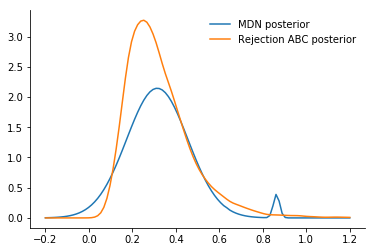

In [81]:
xx = np.linspace(-0.2, 1.2, 100)

pdf = np.array([ss.norm.pdf(xx, mu, sigma) * pi for mu, sigma, pi in zip(out_mu, out_sigma, out_pi)])
pdf = pdf.sum(axis=0)

# read reference (rejection ABC) posterior
rej = pyabc.RejectionSampler.load('/home/dominik/Dropbox/Studium/AppliedCognitiveModelling2017/ABC/03 data/ex02/rej_10000_0.pkl')
rej.Thetas

rej_thetas = rej.Thetas[:,0]
rej_kde = ss.kde.gaussian_kde(rej_thetas)
rej_dens = rej_kde(xx)

f, ax = plt.subplots()
ax.plot(xx, pdf, label='MDN posterior')
ax.plot(xx, rej_dens, label='Rejection ABC posterior')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.legend(frameon=False)